<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Import libraries

In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import product, combinations
from cftime import DatetimeNoLeap
from scipy.stats import ks_2samp, epps_singleton_2samp, ttest_ind, wilcoxon, mannwhitneyu
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
from string import ascii_lowercase, ascii_uppercase


# Functions

In [2]:
def ks_2samp_wrapper(ar1, ar2, signif_t = 0.05):
    _, p = ks_2samp(ar1, ar2)
    return p < signif_t

def ttest_ind_wrapper(ar1, ar2, signif_t = 0.05):
    _, p = ttest_ind(ar1, ar2, equal_var=False)
    return p < signif_t

def wilcoxon_wrapper(ar1, ar2, signig_t = 0.05):
    _, p = wilcoxon(ar1, ar2)
    return p < signif_t

def mannwhitneyu_wrapper(ar1, ar2, signif_t = 0.05):
    _, p = mannwhitneyu(ar1, ar2, alternative='two-sided')
    return p < signif_t

def list_to_dict(ls):
    return dict(ChainMap(*ls))

def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

def generate_DJF_mask(ds):
    mask =  (ds.time.dt.month == 12) | \
    (ds.time.dt.month == 1) | (ds.time.dt.month == 2) 
    return mask

def convert2cftime(dates):
    return [DatetimeNoLeap(*x[0]) for x in product(zip(dates.year, dates.month, dates.day))]    
    

In [3]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 22})

In [4]:
timescale = 20
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'

# Open data

In [5]:
ds = xr.open_dataset(f'{root_path}zg/moment_calculation_w_obj-area_CMAM.nc')#.dropna('time', how='all')
#ds = ds.where(np.isfinite(ds), drop = True)
mask =  (ds.time.dt.month == 12) | \
    (ds.time.dt.month == 1) | (ds.time.dt.month == 2) #| (ds.time.dt.month == 3)
ds_sel = ds.sel(time = mask).dropna('time', how='all')
ds_sel = ds_sel.where(np.isfinite(ds_sel), drop = True)
#ds['time'] = xr.cftime_range('1979-01-01T06', '2010-12-31T18', freq='6H', calendar='noleap')
ds_sel

<xarray.Dataset>
Dimensions:            (time: 2888)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-01 ... 2010-12-31
Data variables:
    aspect_ratio       (time) float64 1.059 1.044 1.093 ... 1.368 1.263 1.193
    centroid_latitude  (time) float64 80.9 80.2 80.13 ... 78.28 78.58 78.31
    objective_area     (time) float64 4.908e+11 4.83e+11 ... 3.631e+11 3.54e+11
    kurtosis           (time) float64 0.2397 0.2268 0.2279 ... 0.1927 0.2038

In [6]:
ds_ratio = xr.open_dataset(f'{root_path}ratio_DailylogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.nc')
ds_ratio['time'] = ds_ratio.indexes['time'].to_datetimeindex()
ds_ratio = ds_ratio.rename({'ratio': 'uref_ratio'})
mask = generate_DJF_mask(ds_ratio)
ds_ratio_sel = ds_ratio.sel(time = mask).dropna('time', how='all')
ds_ratio_sel = ds_ratio_sel.where(np.isfinite(ds_ratio_sel), drop = True)
ds_ratio_sel

/tmp/ipykernel_833965/1813340955.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_ratio['time'] = ds_ratio.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:     (height: 38, time: 2880)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2010-12-31
  * height      (height) int64 11000 12000 13000 14000 ... 46000 47000 48000
    lat         float64 61.23
Data variables:
    uref_ratio  (time, height) float32 16.09 7.669 4.925 ... 0.6985 0.6983

# Data processing

## all lags

In [8]:
ds_sel_dates['central_date'] = df_dates.set_index('BeginDate')

NameError: name 'df_dates' is not defined

In [36]:
ds_sel_dates

<xarray.Dataset>
Dimensions:            (BeginDate: 36, dim_1: 1, time: 25)
Coordinates:
  * time               (time) datetime64[ns] 1980-01-23 ... 2010-12-30
  * BeginDate          (BeginDate) datetime64[ns] 1980-01-13 ... 2010-12-20
  * dim_1              (dim_1) object 'oGWD'
Data variables:
    aspect_ratio       (time) float64 1.421 1.328 1.221 ... 1.983 2.161 1.263
    centroid_latitude  (time) float64 79.67 68.91 81.73 ... 84.41 61.88 78.58
    objective_area     (time) float64 4.376e+11 2.372e+11 ... 3.631e+11
    kurtosis           (time) float64 0.2563 0.1893 0.2992 ... 0.5858 0.1927
    central_date       (BeginDate, dim_1) float64 -10.16 -7.871 ... -7.443

In [7]:
name_ls = ['himalayas','eastasia','westamer']
ds_ls2 = []
max_lag = 10
g_method = 'dayofyear' # 'month'
ds_sel_clim = ds_sel.groupby(f'time.{g_method}').mean('time')
ds_sel_var = ds_sel.groupby(f'time.{g_method}').std('time')
data_var_ls = list(ds_sel.data_vars.keys())
data_var_pv_ls = list(map(lambda x: str(x)+'_pv', data_var_ls))

for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_{timescale}dayts_indexes.csv")
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        dates = df_dates.set_index('BeginDate')

        dates = dates.index +pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        #choose all values within particular day
        #hourly_index_temp = hourly_index[hourly_index.floor('D').isin(dates)]
        #hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
        #ds_ratio.sel(time = convert2cftime(dates), height = 32_000).indexes['time'].to_datetimeindex()
    #print(lag, dates.shape,)
    #print(hourly_index_temp)
        ds_sel_dates = ds.sel(time = dates)
        group_dates = list(ds_sel_dates.groupby(f'time.{g_method}').groups.keys())
        sel_dict = {g_method:group_dates}
        ds_sel_clim_wdates = ds_sel_clim.sel(**sel_dict)
        
        # ks_2samp_wrapper, ttest_ind_wrapper, mannwhitneyu_wrapper
        ds_out = xr.apply_ufunc(ttest_ind_wrapper, ds_sel_dates, ds_sel_clim_wdates, 
               vectorize = True, input_core_dims = [['time'],[g_method]])
        ds_out = ds_out.rename_vars(list_to_dict(list(map(lambda x: {str(x):str(x)+'_pv'}, data_var_ls))))
                                
        ds_clim_m = ds_sel_clim_wdates.mean()
        ds_clim_v = ds_sel_var.sel(**sel_dict).mean()
        ds_ratio_sel = ds_ratio.sel(time = dates, height = 32_000)
        ds_sel_dates_concat = xr.merge([xr.concat([ds_sel_dates, ds_clim_m, ds_clim_v], dim = 'clim_dim'), ds_out, ds_ratio_sel])
        ds_sel_dates_concat['clim_dim'] = ['composite','mean','var']
        #ds_sel_dates_concat['stat_dim'] = ['value','p-value']
        ds_ls.append(ds_sel_dates_concat)
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = range(-max_lag, max_lag+1)
    ds_ls2.append(temp)

    

ds_all = xr.concat(ds_ls2, dim = 'what')
ds_all['what'] = name_ls
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
ds_all

<xarray.Dataset>
Dimensions:               (clim_dim: 3, lag: 21, time: 1565, what: 3)
Coordinates:
  * time                  (time) datetime64[ns] 1979-01-06 ... 2010-12-30
    height                int64 32000
    lat                   float64 61.23
  * clim_dim              (clim_dim) <U9 'composite' 'mean' 'var'
  * lag                   (lag) int64 -10 -9 -8 -7 -6 -5 -4 ... 4 5 6 7 8 9 10
  * what                  (what) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    aspect_ratio          (what, lag, clim_dim, time) float64 1.22 ... 0.5022
    centroid_latitude     (what, lag, clim_dim, time) float64 83.54 ... 6.122
    objective_area        (what, lag, clim_dim, time) float64 4.292e+11 ... 1...
    kurtosis              (what, lag, clim_dim, time) float64 0.2214 ... 0.463
    aspect_ratio_pv       (what, lag) bool False False False ... False False
    centroid_latitude_pv  (what, lag) bool False False False ... False False
    objective_area_pv     (what, lag) bool False False False ... False False
    kurtosis_pv           (what, lag) bool False False False ... True False True
    uref_ratio            (what, lag, time) float32 0.8976 nan ... nan 0.6724

In [8]:
df_all = ds_all[data_var_ls+['uref_ratio']].to_array().to_dataframe(name = 'moments').reset_index()#.drop(columns=['time'])#)
#df_all = ds_all[data_var_pv_ls].to_array().to_dataframe(name = 'moments').reset_index().drop(columns=['time'])#)
df_clim = ds_sel.to_array().to_dataframe(name = 'moments').reset_index().drop(columns=['time'])
df_clim['what'] = ['clim']*df_clim.shape[0]
#df_clim['lag'] = [0]*df_clim.shape[0]
df_merged = pd.concat([df_clim, df_all])
#df_all = df_all.reset_index()
#df_clim = df_clim.reset_index()
#df_merged.head()
df_all.head()

,variable,what,lag,clim_dim,time,height,lat,moments
0,aspect_ratio,himalayas,-10,composite,1979-01-06,32000,61.231573,1.219892
1,aspect_ratio,himalayas,-10,composite,1979-01-07,32000,61.231573,NaN
2,aspect_ratio,himalayas,-10,composite,1979-01-08,32000,61.231573,NaN
3,aspect_ratio,himalayas,-10,composite,1979-01-09,32000,61.231573,NaN
4,aspect_ratio,himalayas,-10,composite,1979-01-10,32000,61.231573,NaN


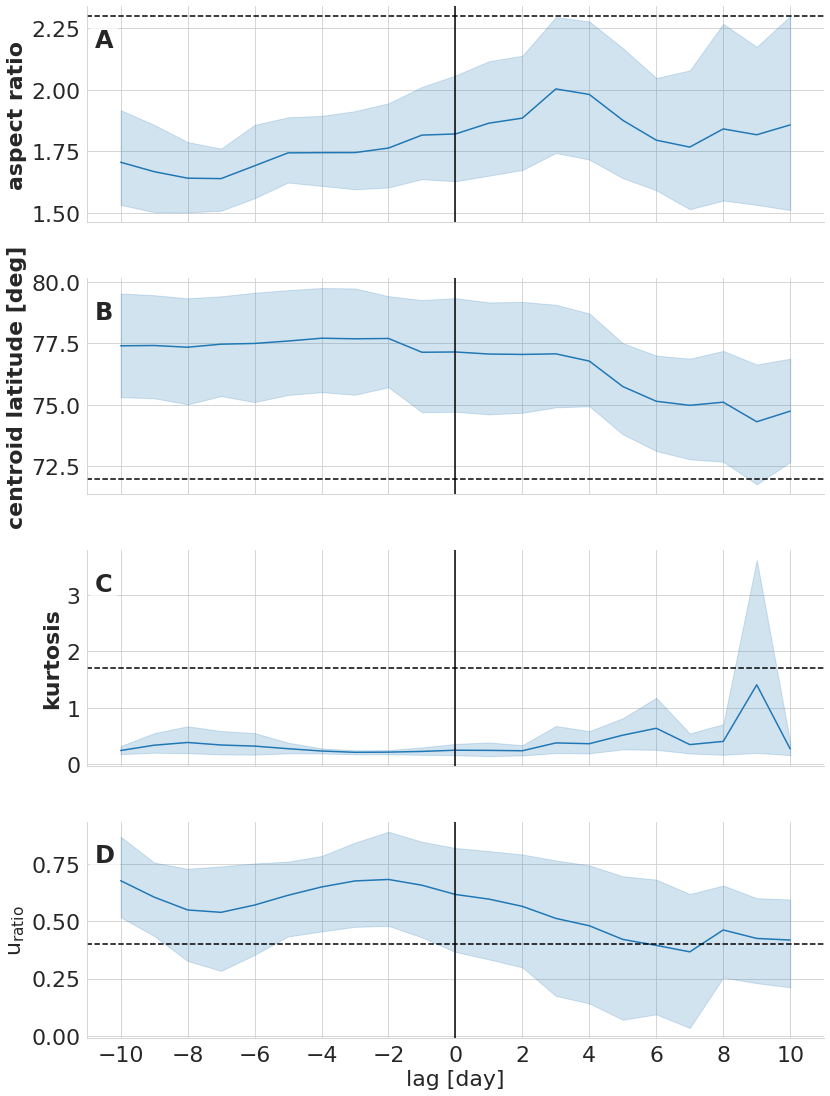

In [9]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
mask = (df_all['clim_dim'] == 'composite') & (df_all['what'] == sel_what) & (df_all['variable'] != 'objective_area')
data = df_all[mask]#.drop(columns = '')

g = sns.FacetGrid(
    data, 
    row = 'variable', 
    sharey='row', 
    height = 4, 
    aspect = 3,
    margin_titles = False
)
g.map(sns.lineplot, "lag", "moments")#, n_boot=10000)
g.map(plt.axvline, x=0, c='k')
g.axes[0][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[-1][0].set_xlabel('lag [day]')

g.axes[0][0].set_ylabel('aspect ratio', fontdict=dict(fontweight = 'bold'))
g.axes[1][0].set_ylabel('centroid latitude [deg]', fontdict=dict(fontweight = 'bold'))#, labelpad = 25)
#g.axes[1][0].yaxis.set_label_coords(-0.05,-0.25)
g.axes[2][0].set_ylabel('kurtosis', fontdict=dict(fontweight = 'bold'))
g.axes[3][0].set_ylabel(r'$\mathbf{\mathrm{u_{ratio}}}$', fontdict=dict(fontweight = 'bold'))

for i, (row_val, ax) in enumerate(g.axes_dict.items()):
    #print(row_val)
    """ if row_val != 'ratio':
        mask = (df_all['what'] == col_val) & (df_all['variable'] == row_val)
        temp = df_all[mask]
        
        mask = (temp['clim_dim'] == 'mean')# & (temp['stat_dim'] == 'value')
        m = temp[mask][['moments','lag']].dropna()
        #s = temp[temp['clim_dim'] == 'var'][['moments','lag']].dropna()
        #ax.fill_between(s['lag'], m['moments'].values+s['moments'].values,m['moments'].values-s['moments'].values, alpha = 0.7, color = 'gray')
        m.plot(x='lag', y = 'moments', color = 'gray', ax = ax, lw = 3, legend=False)
        pv_mask = ds_all[data_var_pv_ls].sel(what = col_val)[f'{row_val}_pv'].values
        m.drop_duplicates()[pv_mask].plot(x='lag', y = 'moments', color = 'gray', ax = ax, lw = 3, legend=False, kind = 'scatter')

        # values below are adopted from Tab. 2 https://journals.ametsoc.org/view/journals/atsc/68/6/2010jas3555.1.xml?tab_body=fulltext-display (other from Seviour's paper)
    """
    ax.set_title('')
    ax.text(0.01, 0.9, ascii_uppercase[i], transform=ax.transAxes,
                      fontsize=24, fontweight='bold', va='top', 
            bbox={'alpha': 0.7, 'facecolor': 'white'})
    try:
        ax.axhline(threshold_dict[row_val],-max_lag,max_lag, linestyle='dashed', color = 'k')
    except:
        pass
    
plt.savefig('PVmoments_lagA_composite_20days_poster.pdf', bbox_inches = 'tight')

In [15]:
df_all

,variable,what,lag,clim_dim,time,height,lat,moments
0,aspect_ratio,himalayas,-10,composite,1979-01-06,32000,61.231573,1.219892
1,aspect_ratio,himalayas,-10,composite,1979-01-07,32000,61.231573,NaN
2,aspect_ratio,himalayas,-10,composite,1979-01-08,32000,61.231573,NaN
3,aspect_ratio,himalayas,-10,composite,1979-01-09,32000,61.231573,NaN
4,aspect_ratio,himalayas,-10,composite,1979-01-10,32000,61.231573,NaN
...,...,...,...,...,...,...,...,...
1478920,uref_ratio,westamer,10,var,2010-12-26,32000,61.231573,NaN
1478921,uref_ratio,westamer,10,var,2010-12-27,32000,61.231573,NaN
1478922,uref_ratio,westamer,10,var,2010-12-28,32000,61.231573,NaN
1478923,uref_ratio,westamer,10,var,2010-12-29,32000,61.231573,NaN


In [21]:
data

,variable,what,lag,clim_dim,time,height,lat,moments
0,aspect_ratio,himalayas,-10,composite,284428800000000000,32000,61.231573,1.219892
1,aspect_ratio,himalayas,-10,composite,284515200000000000,32000,61.231573,NaN
2,aspect_ratio,himalayas,-10,composite,284601600000000000,32000,61.231573,NaN
3,aspect_ratio,himalayas,-10,composite,284688000000000000,32000,61.231573,NaN
4,aspect_ratio,himalayas,-10,composite,284774400000000000,32000,61.231573,NaN
...,...,...,...,...,...,...,...,...
1278600,uref_ratio,himalayas,10,composite,1293321600000000000,32000,61.231573,NaN
1278601,uref_ratio,himalayas,10,composite,1293408000000000000,32000,61.231573,NaN
1278602,uref_ratio,himalayas,10,composite,1293494400000000000,32000,61.231573,NaN
1278603,uref_ratio,himalayas,10,composite,1293580800000000000,32000,61.231573,NaN


In [25]:
dots = sns.load_dataset("dots").query("align == 'dots'")
dots.head()

,align,choice,time,coherence,firing_rate
0,dots,T1,-80,0.0,33.189967
1,dots,T1,-80,3.2,31.691726
2,dots,T1,-80,6.4,34.279840
3,dots,T1,-80,12.8,32.631874
4,dots,T1,-80,25.6,35.060487


<AxesSubplot:xlabel='time', ylabel='firing_rate'>

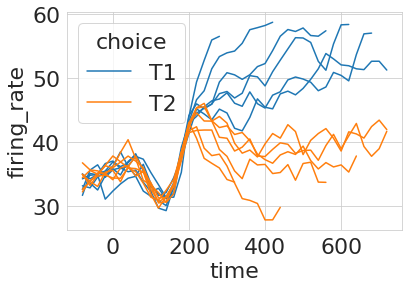

In [27]:


sns.lineplot(
    data=dots, x="time", y="firing_rate", units="coherence", hue = 'choice', estimator = None,
)

In [33]:
 data[data['variable'] == 'kurtosis'].dropna()

,variable,what,lag,clim_dim,time,height,lat,moments
887355,kurtosis,himalayas,-10,composite,284428800000000000,32000,61.231573,0.221432
887376,kurtosis,himalayas,-10,composite,287452800000000000,32000,61.231573,0.224301
887502,kurtosis,himalayas,-10,composite,350697600000000000,32000,61.231573,0.223947
887542,kurtosis,himalayas,-10,composite,379555200000000000,32000,61.231573,0.511178
887572,kurtosis,himalayas,-10,composite,382147200000000000,32000,61.231573,0.297493
...,...,...,...,...,...,...,...,...
982524,kurtosis,himalayas,10,composite,1168560000000000000,32000,61.231573,0.188548
982603,kurtosis,himalayas,10,composite,1201737600000000000,32000,61.231573,0.197831
982655,kurtosis,himalayas,10,composite,1230422400000000000,32000,61.231573,0.173710
982683,kurtosis,himalayas,10,composite,1233446400000000000,32000,61.231573,1.495696


<AxesSubplot:xlabel='time', ylabel='moments'>

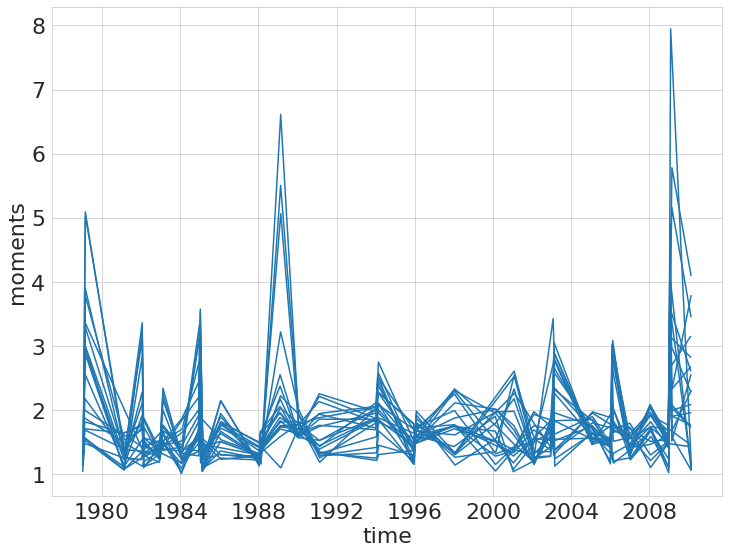

In [43]:
fig = plt.figure(figsize = (12,9))
sns.lineplot(
    data = data[data['variable'] == 'aspect_ratio'],  
    x="time", 
    y="moments", 
    units = 'lag', 
    estimator = None,
)

ValueError: Could not interpret value `time` for parameter `units`

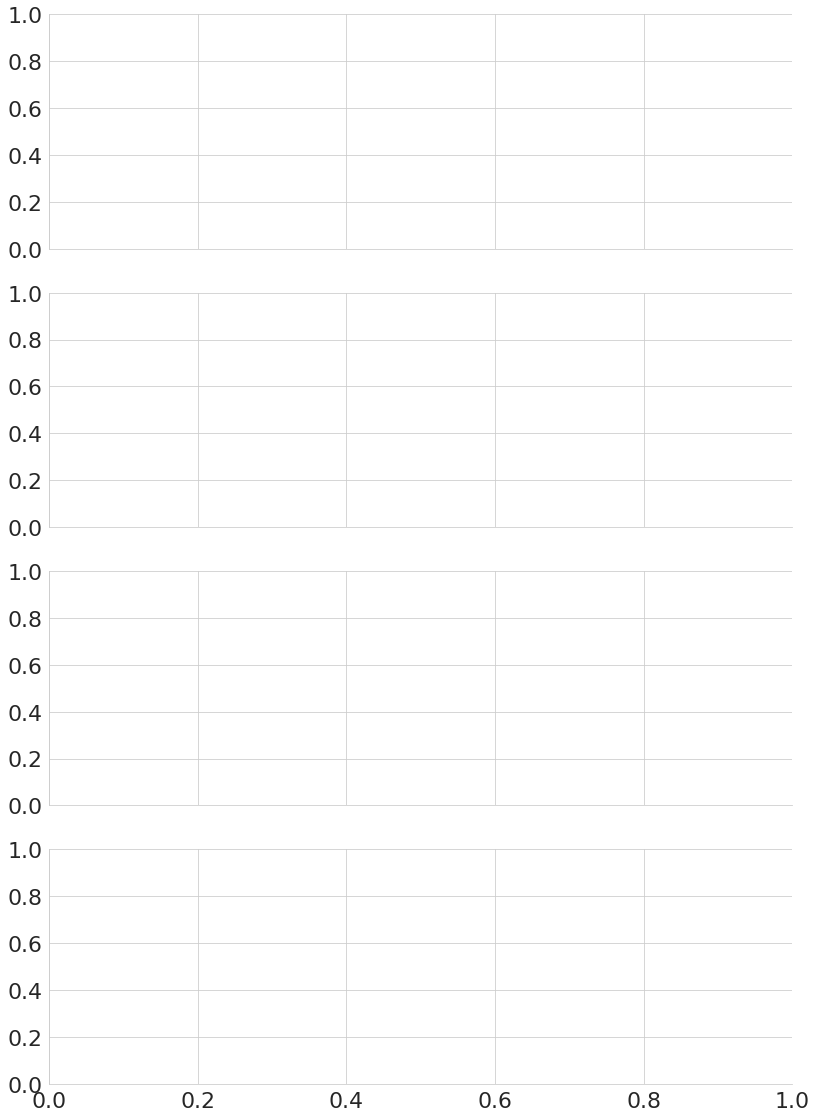

In [40]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
mask = (df_all['clim_dim'] == 'composite') & (df_all['what'] == sel_what) & (df_all['variable'] != 'objective_area')
data = df_all[mask]#.drop(columns = '')
#data['time'] = pd.to_numeric(data.time.values)

g = sns.FacetGrid(data, row = 'variable', sharey='row', height = 4, aspect = 3)#, margin_titles = True)
g.map(sns.lineplot, "lag", "moments", units = 'time')#, n_boot=10000)
g.map(plt.axvline, x=0, c='k')
g.axes[0][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[-1][0].set_xlabel('lag [day]')

for i, (row_val, ax) in enumerate(g.axes_dict.items()):
    #print(row_val)
    """ if row_val != 'ratio':
        mask = (df_all['what'] == col_val) & (df_all['variable'] == row_val)
        temp = df_all[mask]
        
        mask = (temp['clim_dim'] == 'mean')# & (temp['stat_dim'] == 'value')
        m = temp[mask][['moments','lag']].dropna()
        #s = temp[temp['clim_dim'] == 'var'][['moments','lag']].dropna()
        #ax.fill_between(s['lag'], m['moments'].values+s['moments'].values,m['moments'].values-s['moments'].values, alpha = 0.7, color = 'gray')
        m.plot(x='lag', y = 'moments', color = 'gray', ax = ax, lw = 3, legend=False)
        pv_mask = ds_all[data_var_pv_ls].sel(what = col_val)[f'{row_val}_pv'].values
        m.drop_duplicates()[pv_mask].plot(x='lag', y = 'moments', color = 'gray', ax = ax, lw = 3, legend=False, kind = 'scatter')

        # values below are adopted from Tab. 2 https://journals.ametsoc.org/view/journals/atsc/68/6/2010jas3555.1.xml?tab_body=fulltext-display (other from Seviour's paper)
    """
    ax.set_title('')
    ax.text(0.01, 0.9, ascii_uppercase[i], transform=ax.transAxes,
                      fontsize=24, fontweight='bold', va='top', 
            bbox={'alpha': 0.7, 'facecolor': 'white'})
    try:
        ax.axhline(threshold_dict[row_val],-max_lag,max_lag, linestyle='dashed', color = 'k')
    except:
        pass
    
#plt.savefig('PVmoments_lagA_composite_20days.pdf', bbox_inches = 'tight')

In [15]:
fig = plt.figure(figsize=(12,9)) # palette="crest",
sns.kdeplot(data=df_sel, x="moments", 
              hue = "lag", cumulative=False, common_norm=True, common_grid=True, lw = 3)
sns.despine(left=True)
plt.vlines(2.4,0,0.1, linestyles='dashed', color = 'k')
plt.xlabel('aspect ratio')
plt.xlim(2,)
plt.ylim(0,0.1)

NameError: name 'df_sel' is not defined

<Figure size 864x648 with 0 Axes>

First line is (-3,3]. Check colors [here](https://www.rapidtables.com/convert/color/rgb-to-cmyk.html).

## limited lags

In [411]:
name_ls = ['himalayas','eastasia','westamer']
ds_ls2 = []
max_lag = 3
min_lag = -3
g_method = 'dayofyear' # 'month'
ds_sel_clim = ds_sel.groupby(f'time.{g_method}').mean('time')
ds_sel_var = ds_sel.groupby(f'time.{g_method}').std('time')
for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
    
    ds_ls = []
    for il, lag in enumerate(range(min_lag,max_lag+1)):
        dates = df_dates.set_index('BeginDate')

        dates = dates.index +pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        #choose all values within particular day
        #hourly_index_temp = hourly_index[hourly_index.floor('D').isin(dates)]
        #hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]

    #print(lag, dates.shape,)
    #print(hourly_index_temp)
        ds_sel_dates = ds.sel(time = dates)
        group_dates = list(ds_sel_dates.groupby(f'time.{g_method}').groups.keys())
        sel_dict = {g_method:group_dates}
        ds_clim_m = ds_sel_clim.sel(**sel_dict).mean()
        ds_clim_v = ds_sel_var.sel(**sel_dict).mean()
        ds_sel_dates_concat = xr.concat([ds_sel_dates, ds_clim_m, ds_clim_v], dim = 'clim_dim')
        ds_sel_dates_concat['clim_dim'] = ['composite','mean','var']
        ds_ls.append(ds_sel_dates_concat)
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = range(min_lag, max_lag+1)
    ds_ls2.append(temp)

    

ds_all = xr.concat(ds_ls2, dim = 'what')
ds_all['what'] = name_ls
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
#ds_all['aspect_ratio'] = ds_all['aspect_ratio'].dropna('time', how = 'all')
ds_all

<xarray.Dataset>
Dimensions:            (clim_dim: 3, lag: 7, time: 649, what: 3)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-13 ... 2010-12-23
  * clim_dim           (clim_dim) <U9 'composite' 'mean' 'var'
  * lag                (lag) int64 -3 -2 -1 0 1 2 3
  * what               (what) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    aspect_ratio       (what, lag, clim_dim, time) float64 1.257 nan ... 0.4966
    centroid_latitude  (what, lag, clim_dim, time) float64 78.69 nan ... 6.123
    objective_area     (what, lag, clim_dim, time) float64 4.63e+11 ... 1.183...
    kurtosis           (what, lag, clim_dim, time) float64 0.2103 nan ... 0.5681

In [16]:
df_all = ds_all.sel(clim_dim = 'composite').to_array().to_dataframe(name = 'moments').reset_index().drop(columns=['lag','time','clim_dim'])#)
df_clim = ds_sel.to_array().to_dataframe(name = 'moments').reset_index().drop(columns=['time'])
df_clim['what'] = ['clim']*df_clim.shape[0]
df_merged = pd.concat([df_clim, df_all])
#df_all = df_all.reset_index()
#df_clim = df_clim.reset_index()
df_all.head()

,variable,what,height,lat,moments
0,aspect_ratio,himalayas,32000,61.231573,1.219892
1,aspect_ratio,himalayas,32000,61.231573,NaN
2,aspect_ratio,himalayas,32000,61.231573,NaN
3,aspect_ratio,himalayas,32000,61.231573,NaN
4,aspect_ratio,himalayas,32000,61.231573,NaN


### CDF visualization

#### Aspect ratio

Text(0.5, 0, 'aspect ratio')

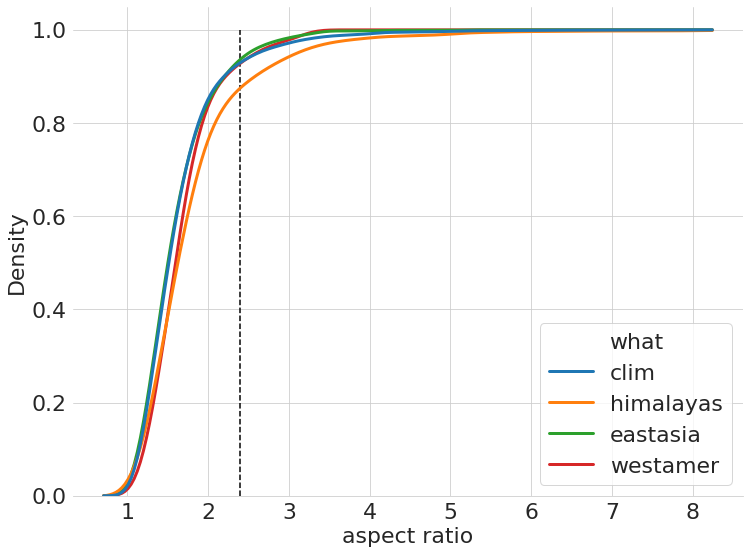

In [17]:
fig = plt.figure(figsize=(12,9))
data = df_merged[df_merged['variable'] == 'aspect_ratio']
sns.kdeplot(data=data, x="moments", 
              hue = "what", cumulative=True, common_norm=False, common_grid=True, lw = 3)
sns.despine(left=True)
plt.vlines(2.4,0,1, linestyles='dashed', color = 'k')
plt.xlabel('aspect ratio')

Text(0.5, 0, 'aspect ratio')

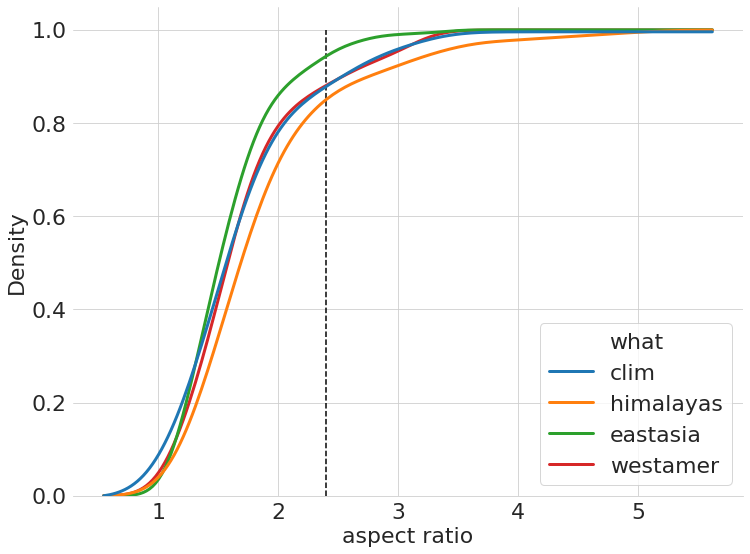

In [109]:
fig = plt.figure(figsize=(12,9))
sns.kdeplot(data=df_merged[df_merged['variable'] == 'aspect_ratio'], x="moments", 
              hue = "what", cumulative=True, common_norm=False, common_grid=True, lw = 3)
sns.despine(left=True)
plt.vlines(2.4,0,1, linestyles='dashed', color = 'k')
plt.xlabel('aspect ratio')

Text(0.5, 0, 'centroid_latitude')

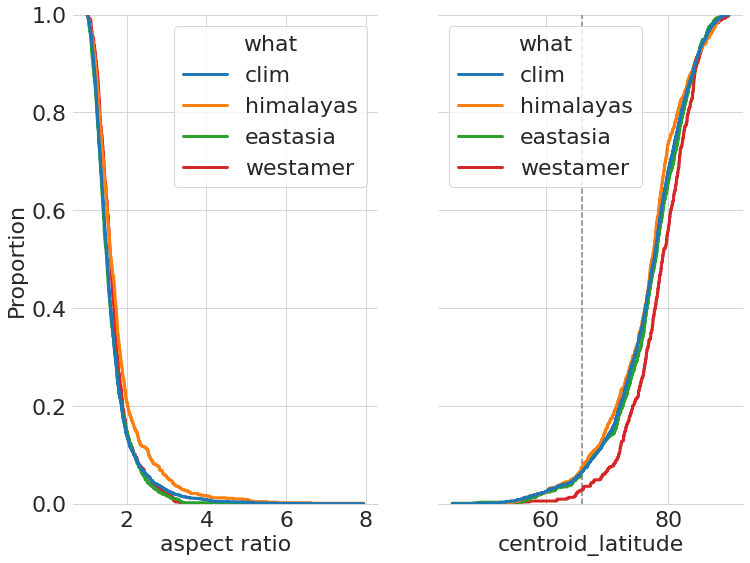

<Figure size 864x648 with 0 Axes>

In [31]:
fig = plt.figure(figsize=(12,9))
axes = fig.subplots(ncols = 2, sharey=True)
ax1 = axes[0]
sns.ecdfplot(data=df_merged[df_merged['variable'] == 'aspect_ratio'], x="moments", 
              hue = "what", complementary = True, lw = 3, ax = ax1)

sns.despine(left=True)
ax1.set_xlabel('aspect ratio')

ax2 = axes[1]
fig = plt.figure(figsize=(12,9))
sns.ecdfplot(data=df_merged[df_merged['variable'] == 'centroid_latitude'], x="moments", 
              hue = "what", lw = 3, ax = ax2)
sns.despine(left=True)
ax2.vlines(66,0,1, linestyles='dashed', color = 'grey')
ax2.set_xlabel('centroid_latitude')

Text(0.5, 0, 'aspect ratio')

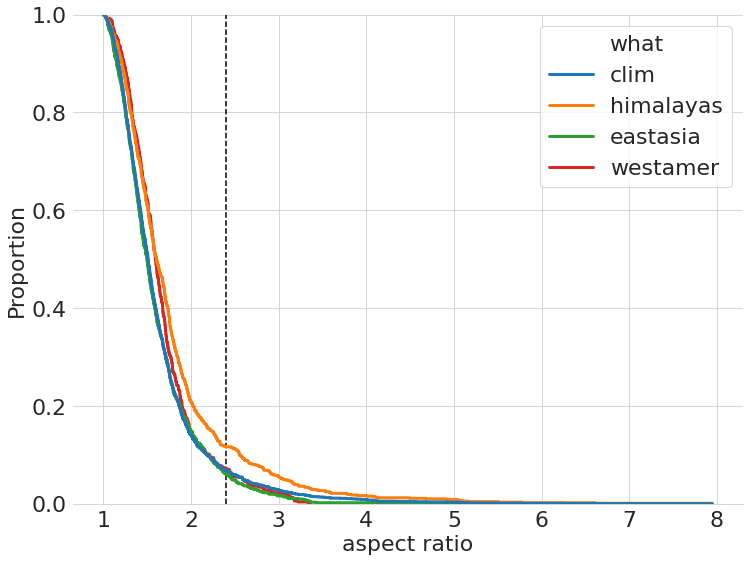

In [18]:
fig = plt.figure(figsize=(12,9))
axes = fig.subplots(ncols = 2)
sns.ecdfplot(data=df_merged[df_merged['variable'] == 'aspect_ratio'], x="moments", 
              hue = "what", complementary = True, lw = 3)
sns.despine(left=True)
plt.vlines(2.4,0,1, linestyles='dashed', color = 'k')
plt.xlabel('aspect ratio')
#plt.xlim(60,)
#plt.ylim(0.9)

#### Objective area

Text(0.5, 0, 'objective area $[\\mathrm{m}^2]$')

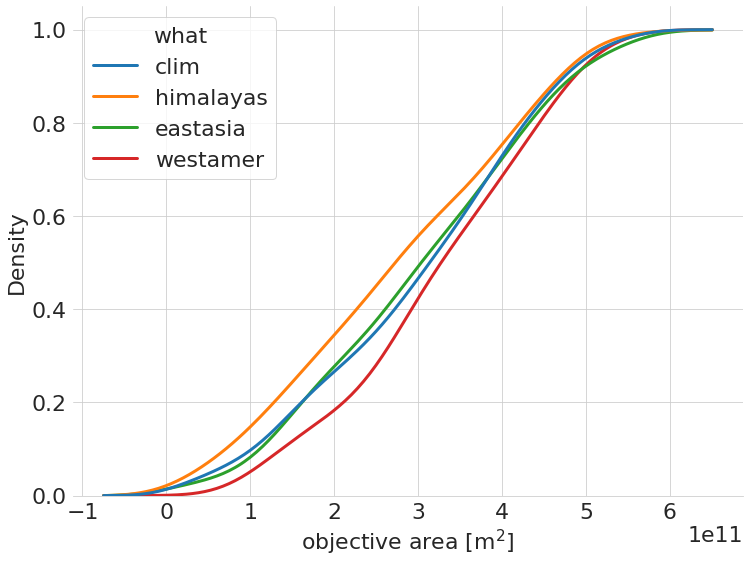

In [19]:
fig = plt.figure(figsize=(12,9))
sns.kdeplot(data=df_merged[df_merged['variable'] == 'objective_area'], x="moments", 
              hue = "what", cumulative=True, common_norm=False, common_grid=True, lw = 3)
sns.despine(left=True)
#plt.vlines(66,0,1, linestyles='dashed')
plt.xlabel(r'objective area $[\mathrm{m}^2]$')

#### Kurtosis

Text(0.5, 0, 'kurtosis')

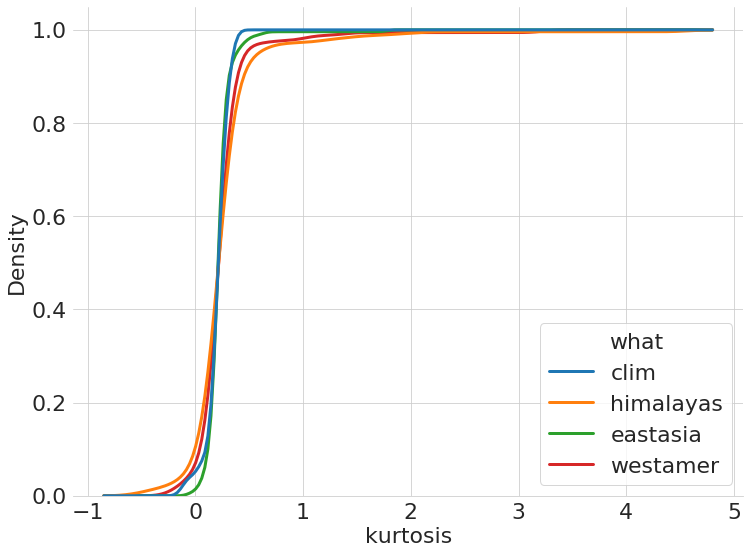

In [30]:
fig = plt.figure(figsize=(12,9))
sns.kdeplot(data=df_merged[df_merged['variable'] == 'kurtosis'], x="moments", 
              hue = "what", cumulative=True, common_norm=False, common_grid=True, lw = 3)
sns.despine(left=True)
#plt.vlines(66,0,1, linestyles='dashed')
plt.xlabel(r'kurtosis')

(0.8, 1.1)

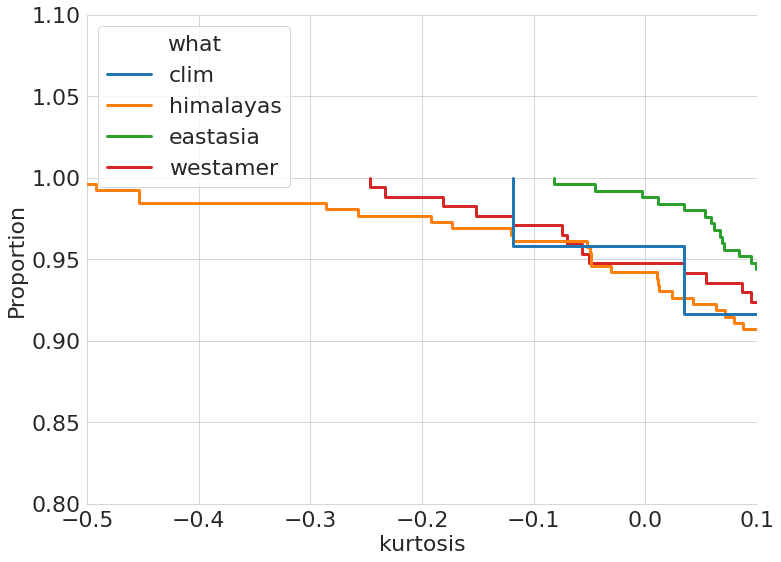

In [116]:
fig = plt.figure(figsize=(12,9))
sns.ecdfplot(data=df_merged[df_merged['variable'] == 'kurtosis'], x="moments", 
              hue = "what", lw = 3, complementary = True)
sns.despine(left=True)
#plt.vlines(66,0,1, linestyles='dashed')
plt.xlabel(r'kurtosis')
plt.xlim(-0.5,0.1)
plt.ylim(0.8,1.1)

(0.0, 0.2)

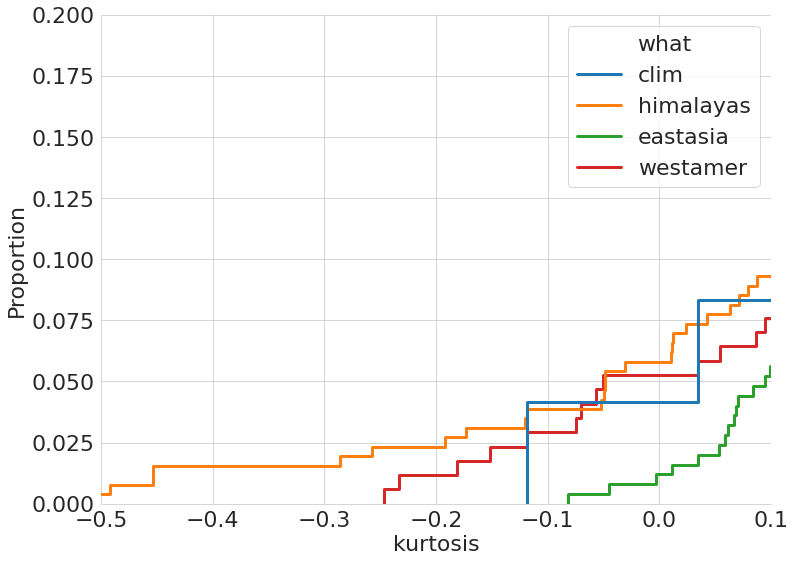

In [120]:
fig = plt.figure(figsize=(12,9))
sns.ecdfplot(data=df_merged[df_merged['variable'] == 'kurtosis'], x="moments", 
              hue = "what", lw = 3, complementary = False)
sns.despine(left=True)
#plt.vlines(66,0,1, linestyles='dashed')
plt.xlabel(r'kurtosis')
plt.xlim(-0.5,0.1)
plt.ylim(0,0.2)

(0.0, 0.2)

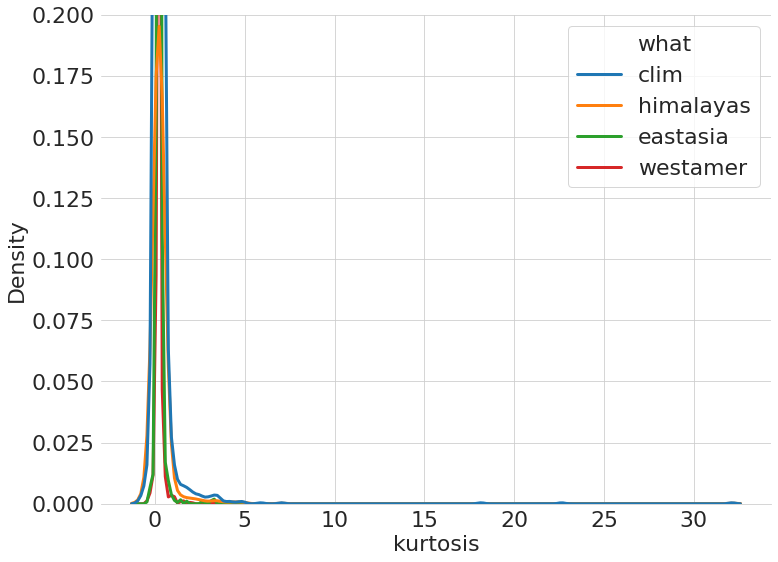

In [22]:
fig = plt.figure(figsize=(12,9))
sns.kdeplot(data=df_merged[df_merged['variable'] == 'kurtosis'], x="moments", 
              hue = "what", lw = 3, common_grid=True)
sns.despine(left=True)
#plt.vlines(66,0,1, linestyles='dashed')
plt.xlabel(r'kurtosis')
#plt.xlim(-0.5,0.1)
plt.ylim(0,0.2)

#### Centroid latitude

Text(0.5, 0, 'centroid_latitude')

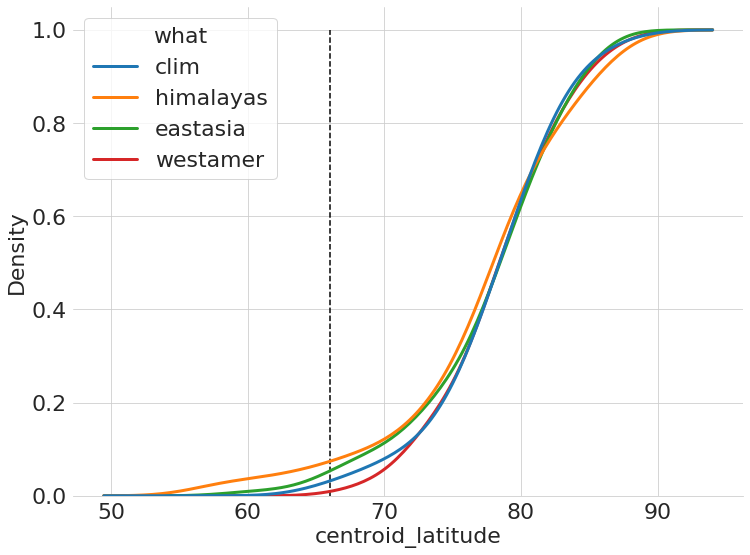

In [10]:
fig = plt.figure(figsize=(12,9))
sns.kdeplot(data=df_merged[df_merged['variable'] == 'centroid_latitude'], x="moments", 
              hue = "what", cumulative=True, common_norm=False, common_grid=True, lw = 3)
sns.despine(left=True)
plt.vlines(66,0,1, linestyles='dashed')
plt.xlabel('centroid_latitude')

Text(0.5, 0, 'centroid_latitude')

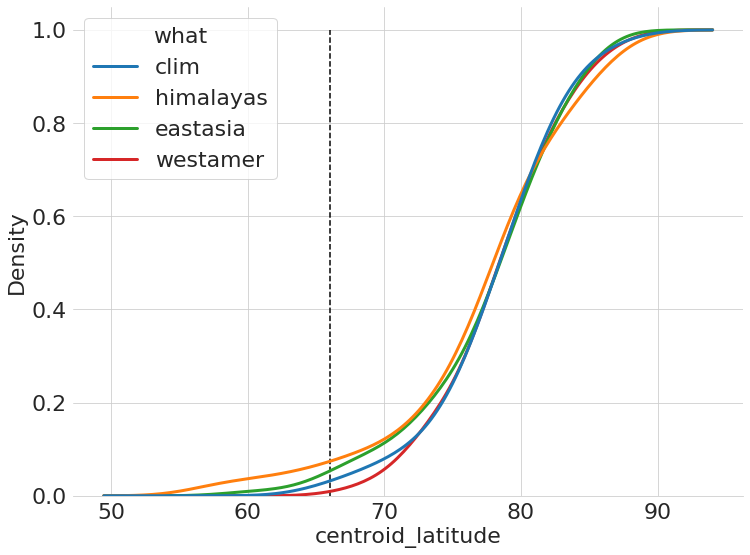

In [182]:
fig = plt.figure(figsize=(12,9))
sns.kdeplot(data=df_merged[df_merged['variable'] == 'centroid_latitude'], x="moments", 
              hue = "what", cumulative=True, common_norm=False, common_grid=True, lw = 3)
sns.despine(left=True)
plt.vlines(66,0,1, linestyles='dashed')
plt.xlabel('centroid_latitude')

Text(0.5, 0, 'centroid_latitude')

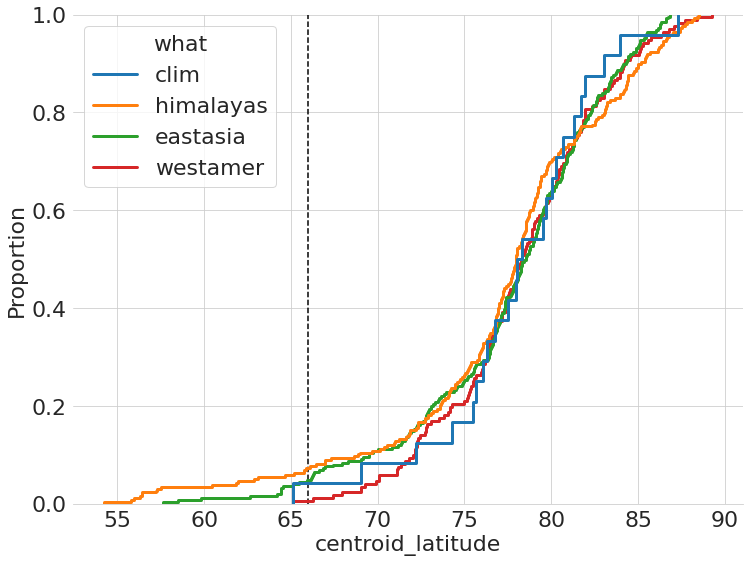

In [126]:
fig = plt.figure(figsize=(12,9))
sns.ecdfplot(data=df_merged[df_merged['variable'] == 'centroid_latitude'], x="moments", 
              hue = "what", complementary = False, lw = 3)
sns.despine(left=True)
plt.vlines(66,0,1, linestyles='dashed', color = 'k')
plt.xlabel('centroid_latitude')